In [1]:
! pip install kaggle

from google.colab import drive
drive.mount('/content/drive')

! cp /content/drive/MyDrive/kaggle.json ~/
! mkdir ~/.kaggle
! mv ~/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
! kaggle datasets download -d eldarsultanow/polytopes-5d-normalized-reflexive
! unzip polytopes-5d-normalized-reflexive.zip

Dataset URL: https://www.kaggle.com/datasets/eldarsultanow/polytopes-5d-normalized-reflexive
License(s): unknown
  0% 0.00/7.29M [00:00<?, ?B/s]
100% 7.29M/7.29M [00:00<00:00, 91.0MB/s]
Archive:  polytopes-5d-normalized-reflexive.zip
  inflating: polytopes_5d_reflexive.txt  


In [36]:
import sys

import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd
pd.set_option('display.max_colwidth', None)

import ast
import re
from ast import literal_eval
from math import gcd
from functools import reduce

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns

!pip install hdbscan
import hdbscan

In [3]:
file_content = ''
with open('polytopes_5d_reflexive.txt', 'r') as file:
    file_content = file.read()

i = 0
lst_polys = []

for line in re.findall(r"^\[.*?\]$", file_content, flags=re.S | re.M):
  try:
    arr, *rest = literal_eval(line.replace("array", ""))
    U, S, Vh = np.linalg.svd(arr, full_matrices=True)
    lst_polys.append([str(arr), np.matrix.trace(U), np.matrix.trace(Vh)] + rest)
    i += 1
  except:
    print("omitting: {0}".format(line))
print("{0} polytopes collected".format(i))

omitting: [['0' '1' '1' '0' '2']
224272 polytopes collected


In [4]:
df = pd.DataFrame(lst_polys, columns=['matrix', 'traceU', 'traceVh', 'vol', 'h11', 'h12', 'h13', 'h22', 'chi', 'numptsM', 'numvertsM', 'numptsN', 'numvertsN'])
df.head()

matrix  \
0                      [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, -1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [-2, -1, 0, -1, -1], [-2, -2, 0, -1, 0]]   
1                       [[1, 0, 0, 0, 0], [-1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [-1, -1, 0, 1, 0], [0, 0, 0, 0, 1], [0, -2, -2, -2, -1]]   
2  [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [-1, 0, -2, -1, -1], [-1, -1, -1, -1, -1], [0, -1, 1, 0, 1], [-1, 0, 1, 1, 0]]   
3                  [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [-2, -1, -1, -1, 0], [-2, -2, 0, -1, 0], [0, 0, 0, 0, 1], [-3, -2, -2, -1, -1]]   
4                     [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [1, -1, -1, 0, 0], [-2, 0, 0, -1, 0], [0, 0, 0, 0, 1], [-2, -1, -1, -2, -1]]   

     traceU   traceVh  vol  h11  h12  h13   h22   chi  numptsM  numvertsM  \
0  0.788875  0.137026   24    4    0  232   988  1464       10          8   
1  0.589976 -0.850823   28    4    0  244  1036  1536       10          8   
2  1.768890 -1.040558   36    4    0  171   744  1098       10          9   
3  1.178932 -1.421765   30    4    0  352  1468  2184       10          8   
4  0.942262 -1.471582   28    4    0  222   948  1404       10          8   

   numptsN  numvertsN  
0      246         12  
1      260         13  
2      181          9  
3      385         14  
4      238         13

In [5]:
df_sub = df.loc[:, df.columns != 'matrix']
df_sub.head()

traceU   traceVh  vol  h11  h12  h13   h22   chi  numptsM  numvertsM  \
0  0.788875  0.137026   24    4    0  232   988  1464       10          8   
1  0.589976 -0.850823   28    4    0  244  1036  1536       10          8   
2  1.768890 -1.040558   36    4    0  171   744  1098       10          9   
3  1.178932 -1.421765   30    4    0  352  1468  2184       10          8   
4  0.942262 -1.471582   28    4    0  222   948  1404       10          8   

   numptsN  numvertsN  
0      246         12  
1      260         13  
2      181          9  
3      385         14  
4      238         13

In [9]:
# dataframe with only 6 pointed polytopes
df_sub_vert6 = df.loc[df.numvertsM == 6]
print(df_sub_vert6.shape)
print(df_sub_vert6['matrix'][:4])

def extract_last_coefficients(matrix_str):
    matrix = ast.literal_eval(matrix_str)
    last_row = matrix[-1]
    return pd.Series(last_row)

temp_df = df['matrix'].apply(lambda x: pd.Series(extract_last_coefficients(x)))
temp_df.columns = ['coef1', 'coef2', 'coef3', 'coef4', 'coef5']

def calculate_gcd(row):
    coefficients = [row['coef1'], row['coef2'], row['coef3'], row['coef4']]
    return reduce(gcd, coefficients)

temp_df['gcd'] = temp_df.apply(calculate_gcd, axis=1)

df_sub_vert6 = pd.concat([df_sub_vert6, temp_df], axis=1)

print(df_sub_vert6[:4])
print(df_sub_vert6['gcd'].value_counts())

(115858, 13)
2369    [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [-12, -4, -4, -2, -1]]
5326    [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [-12, -6, -2, -2, -1]]
5760     [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 3, 0], [0, 0, 0, 0, 1], [-4, -2, -4, -6, -1]]
5765     [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [-6, -6, -6, -4, -1]]
Name: matrix, dtype: object
                                                                                                            matrix  \
2369  [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [-12, -4, -4, -2, -1]]   
5326  [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [-12, -6, -2, -2, -1]]   
5760   [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 1, 3, 0], [0, 0, 0, 0, 1], [-4, -2, -4, -6, -1]]   
5765   [[1, 0, 0, 0

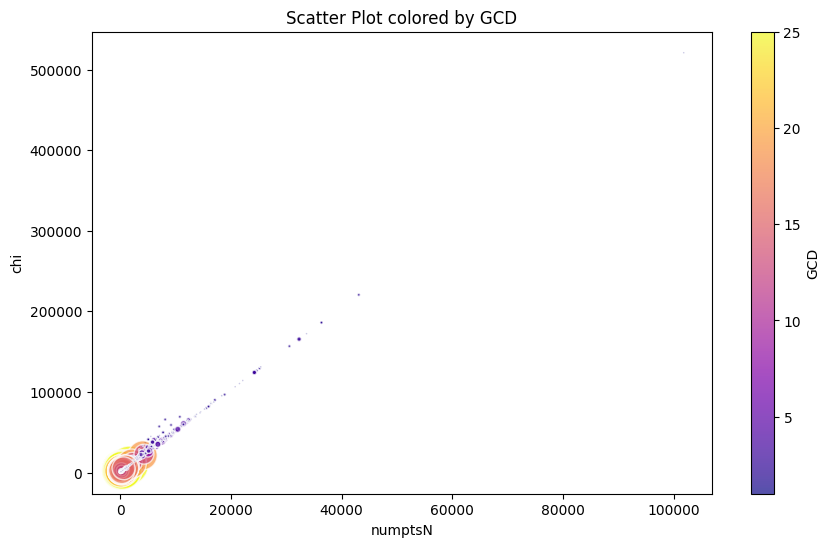

In [37]:
param_x = 'numptsN'
param_y = 'chi'

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_sub_vert6[param_x], df_sub_vert6[param_y], c=df_sub_vert6['gcd'], cmap='plasma', s=(df_sub_vert6['gcd'] * 1.1) ** 2, alpha=0.7, edgecolors='w')

plt.colorbar(scatter, label='GCD')
plt.xlabel(param_x)
plt.ylabel(param_y)
plt.title('Scatter Plot colored by GCD')

plt.show()

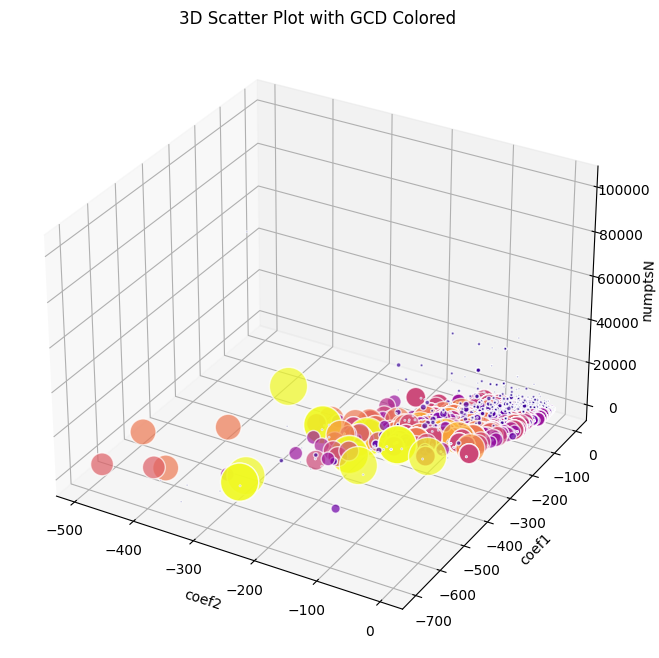

In [58]:
param_x = 'coef2'
param_y = 'coef1'
param_z = 'numptsN'

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

cmap = plt.cm.plasma
norm = plt.Normalize(vmin=df_sub_vert6['gcd'].min(), vmax=df_sub_vert6['gcd'].max())

scatter = ax.scatter(df_sub_vert6[param_x], df_sub_vert6[param_y], df_sub_vert6[param_z], c = cmap(norm(df_sub_vert6['gcd'])), s=(df_sub_vert6['gcd'] * 1.1) ** 2, alpha=0.7, edgecolors='w')
ax.set_xlabel(param_x)
ax.set_ylabel(param_y)
ax.set_zlabel(param_z)
ax.set_title('3D Scatter Plot with GCD Colored')

plt.show()

In [ ]:
df.to_csv('polytopes_5d_reflexive.csv', index=True)

<Axes: xlabel='traceU', ylabel='traceVh'>

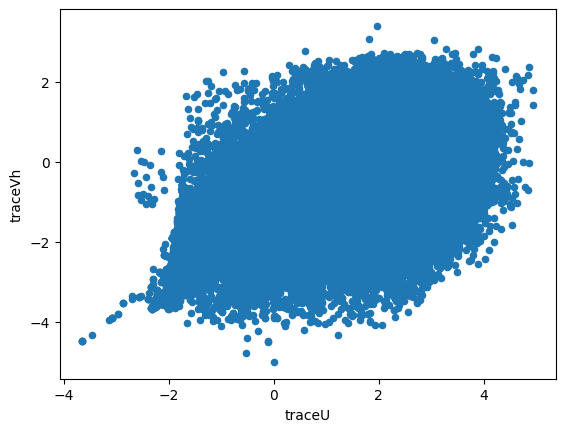

In [ ]:
df.plot.scatter(x='traceU', y='traceVh')

In [ ]:
db = DBSCAN(eps=5, min_samples=5).fit(df_sub)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = pd.DataFrame(db.labels_,columns=['Cluster ID'])
result = pd.concat((df_sub, labels), axis=1)
result.head()

traceU   traceVh  vol  h11  h12  h13   h22   chi  numptsM  numvertsM  \
0  0.788875  0.137026   24    4    0  232   988  1464       10          8   
1  0.589976 -0.850823   28    4    0  244  1036  1536       10          8   
2  1.768890 -1.040558   36    4    0  171   744  1098       10          9   
3  1.178932 -1.421765   30    4    0  352  1468  2184       10          8   
4  0.942262 -1.471582   28    4    0  222   948  1404       10          8   

   numptsN  numvertsN  Cluster ID  
0      246         12           0  
1      260         13           1  
2      181          9           2  
3      385         14           3  
4      238         13           4

<Axes: xlabel='traceU', ylabel='chi'>

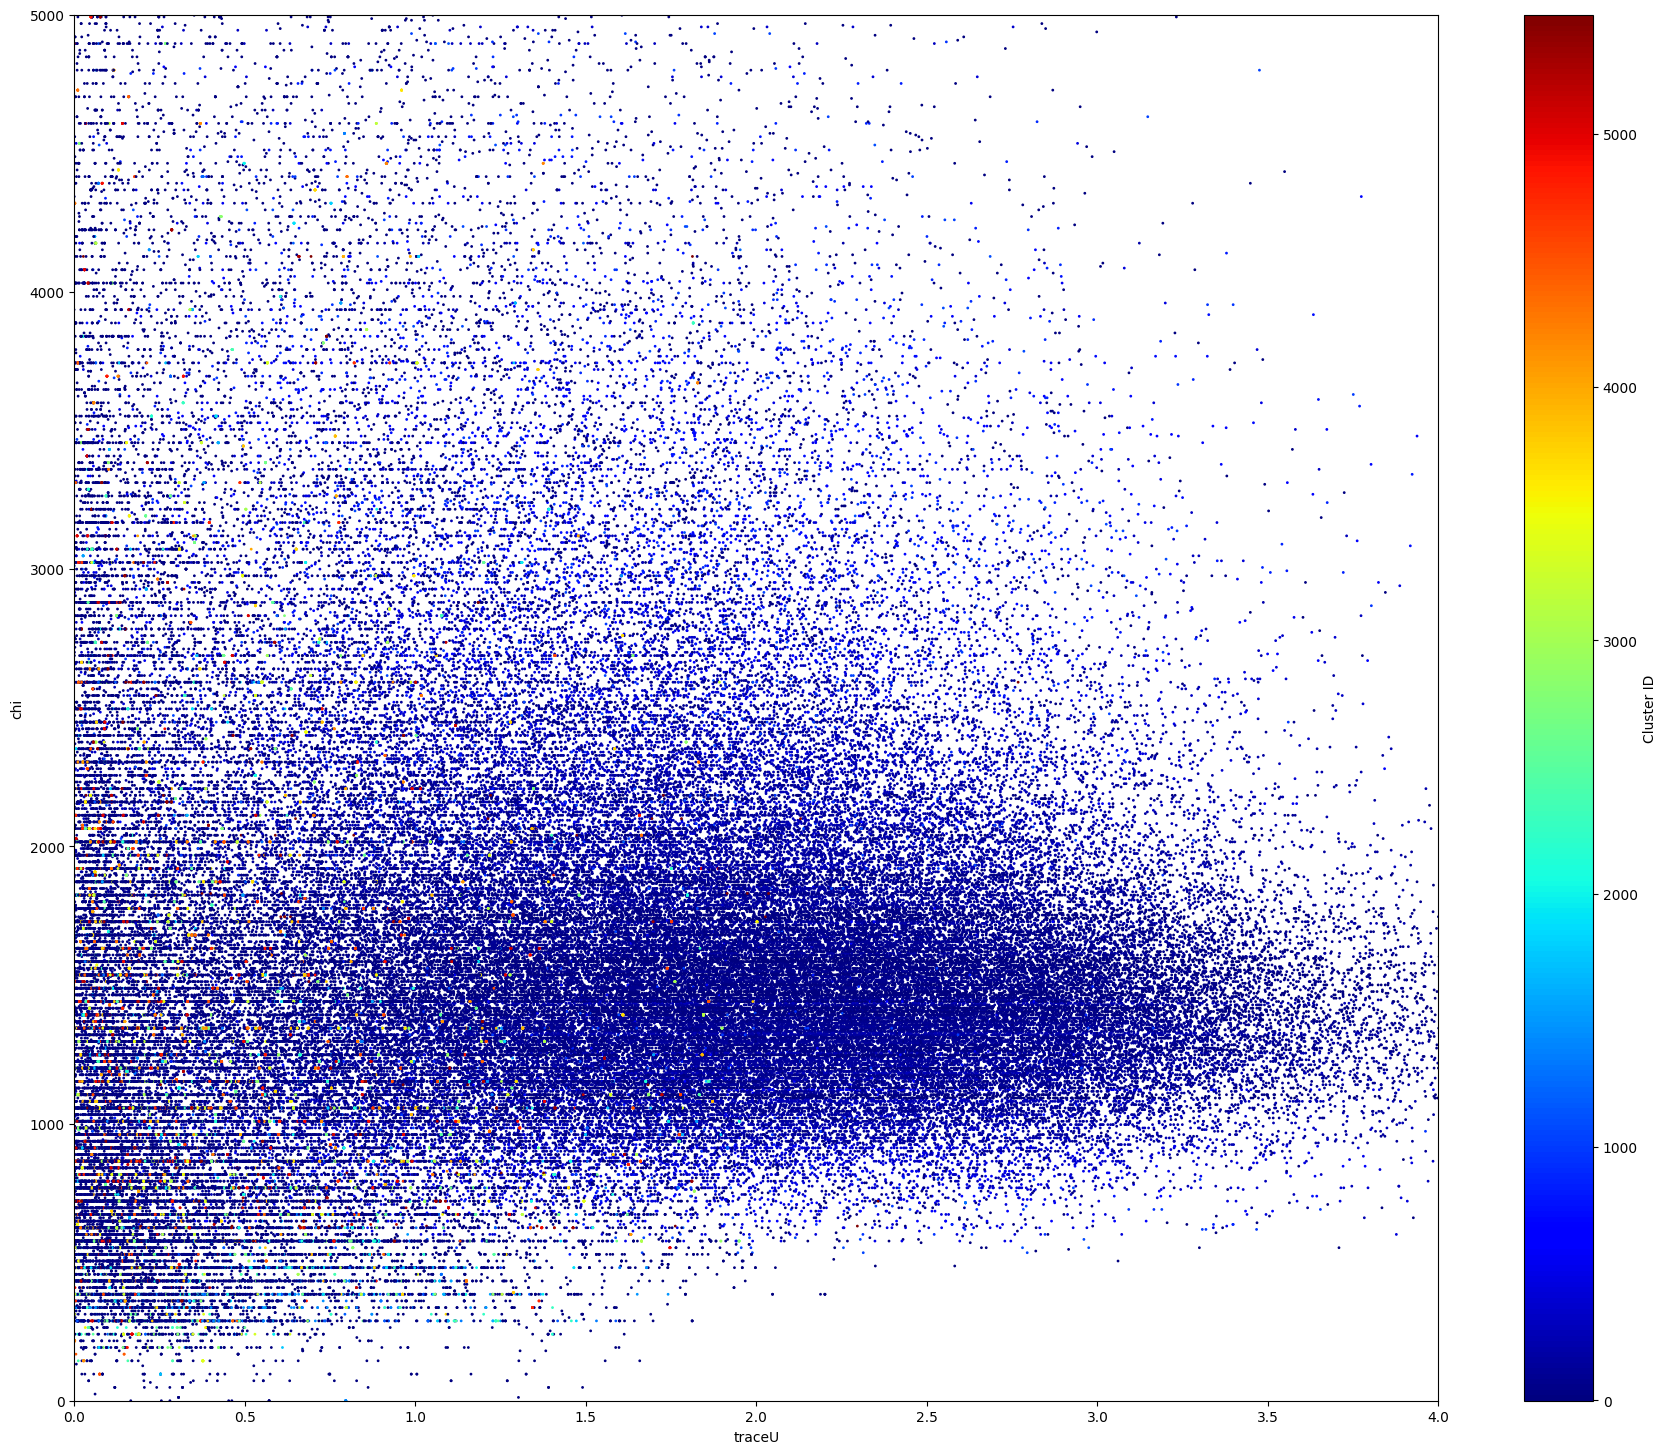

In [ ]:
result.plot.scatter(figsize=(22,18), x='traceU', y='chi', xlim=(0,4), ylim=(0,5000), c='Cluster ID', s=1, colormap='jet')

Find important features

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sub)

model = KMeans(n_clusters=4, init = "k-means++", max_iter = 300, n_init = 10, random_state=42)
df_sub['cluster'] = model.fit_predict(df_scaled)

# Filter out noise points
df_filtered = df_sub[df_sub['cluster'] != -1]

# all columns except 'cluster'
features = df_filtered.columns[:-1]
print(features)

X = df_filtered[features]
y = df_filtered['cluster']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importances = pd.DataFrame(rf.feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

Index(['traceU', 'traceVh', 'vol', 'h11', 'h12', 'h13', 'h22', 'chi',
       'numptsM', 'numvertsM', 'numptsN', 'numvertsN'],
      dtype='object')
           importance
numvertsM    0.250977
numptsM      0.203718
vol          0.166191
numvertsN    0.133680
h11          0.091811
traceU       0.070490
h12          0.020300
h13          0.016915
numptsN      0.014252
chi          0.011080
h22          0.010692
traceVh      0.009894


Find the optimal number of clusters using elbow method

In [ ]:
cluster_cols = ['numptsM','h11','h12']
x = df[cluster_cols].values

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

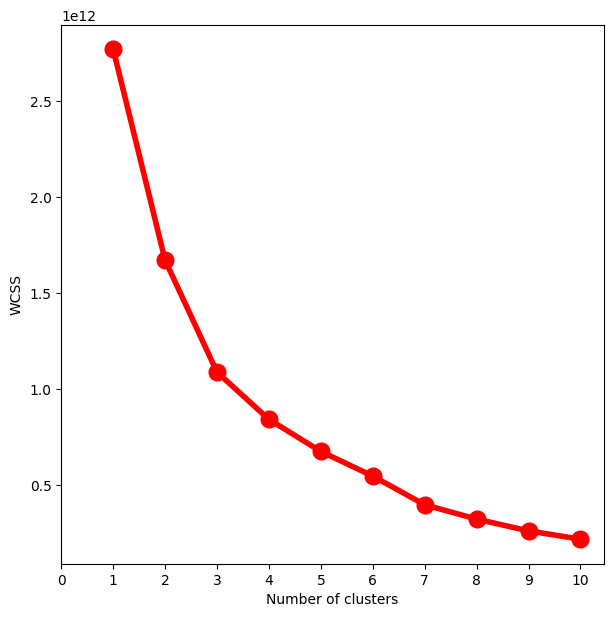

In [ ]:
WCSS = []
for i in range(1,11):
    model = KMeans(n_clusters = i, init = 'k-means++')
    model.fit(x)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(1,11),WCSS, linewidth=4, markersize=12,marker='o',color = 'red')
plt.xticks(np.arange(11))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [ ]:
model = KMeans(n_clusters = 4, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_clusters = model.fit_predict(x)

In [ ]:
model = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=10, cluster_selection_epsilon=50)
y_clusters = model.fit_predict(x)
unique_clusters, unique_cluster_counts = np.unique(y_clusters, return_counts=True)
count_pairs = np.asarray((unique_clusters, unique_cluster_counts)).T
count_pairs = count_pairs[np.argsort(-count_pairs[:, 1])]
num_clusters = len(count_pairs)

num_colors = num_clusters if num_clusters < 20 else 20

print(count_pairs[:10])
print(num_clusters)

[[     1 224177]
 [    -1     49]
 [     2     17]
 [     0     16]
 [     3     13]]
5


3D Scatterplot of the clusters

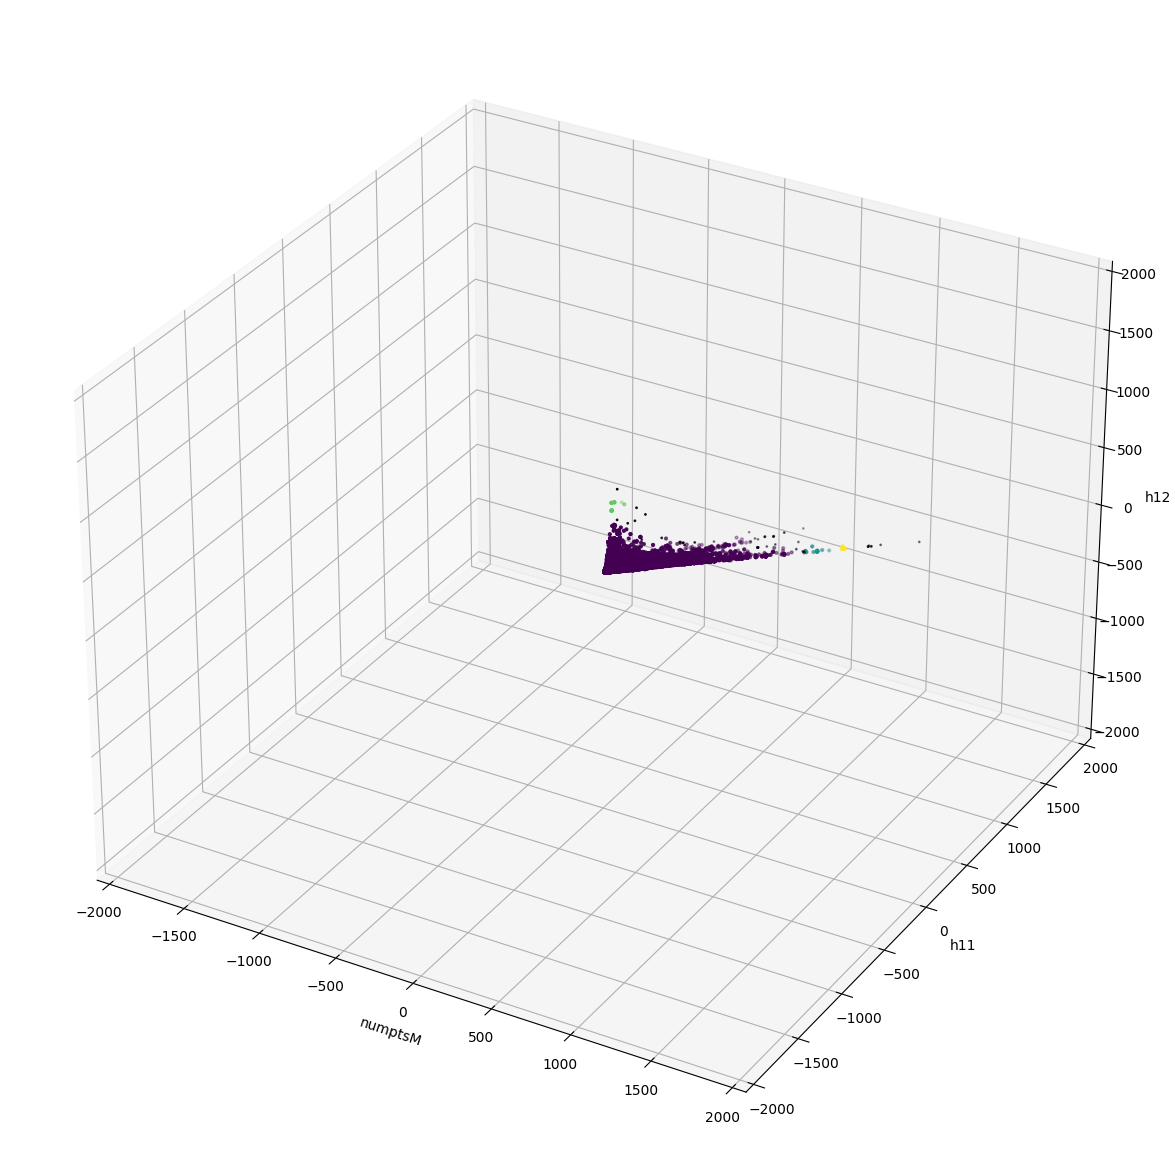

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')

colormap = colormaps['viridis'].resampled(num_colors)

# add points of clusters to highlight
for i in range(0, num_colors):
  cluster_val = count_pairs[i, 0]
  if cluster_val != -1:
    mask = y_clusters == cluster_val
    ax.scatter(x[mask, 0],
               x[mask, 1],
               x[mask, 2],
               s = 4,
               color = colormap(i),
               label = "cluster {0}".format(i))

# add points of remaining clusters
for i in range(num_colors, num_clusters):
  cluster_val = count_pairs[i, 0]
  if cluster_val != -1:
    mask = y_clusters == cluster_val
    ax.scatter(x[mask, 0],
               x[mask, 1],
               x[mask, 2],
               s = 1,
               color = "black",
               label = "cluster {0}".format(i))

# add non-clustered points
mask = y_clusters == -1
ax.scatter(x[mask, 0],
           x[mask, 1],
           x[mask, 2],
           s = 1,
           color = "black",
           label = "non-clustered values")

ax.set_xlim([-2000, 2000])
ax.set_ylim([-2000, 2000])
ax.set_zlim([-2000, 2000])
ax.set_xlabel(cluster_cols[0])
ax.set_ylabel(cluster_cols[1])
ax.set_zlabel(cluster_cols[2])
#ax.legend()
plt.show()

In [ ]:
import plotly.graph_objs as go
import plotly.express as px
from plotly import tools
from plotly.subplots import make_subplots

fig = go.Figure()

Scene = dict(
    xaxis = dict(title = cluster_cols[0], range=[0,150]),
    yaxis = dict(title = cluster_cols[1], range=[0,150]),
    zaxis = dict(title = cluster_cols[2], range=[0,1500]))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = model.labels_

colormap = px.colors.sequential.Viridis
colors = px.colors.sample_colorscale(colormap, [i / num_colors for i in range(num_colors)])

# add points of clusters to highlight
for i in range(0, num_colors):
  cluster_val = count_pairs[i, 0]
  if cluster_val != -1:
    mask = y_clusters == cluster_val
    fig.add_trace(go.Scatter3d(
        x=x[mask, 0],
        y=x[mask, 1],
        z=x[mask, 2],
        mode='markers',
        marker=dict(color=colors[i % num_colors], size=2, line=dict(width=0)),
        name="cluster {0}".format(i),
        showlegend=False
    ))

# add points of remaining clusters
for i in range(num_colors, num_clusters):
  cluster_val = count_pairs[i, 0]
  if cluster_val != -1:
    mask = y_clusters == cluster_val
    fig.add_trace(go.Scatter3d(
        x=x[mask, 0],
        y=x[mask, 1],
        z=x[mask, 2],
        mode='markers',
        marker=dict(color="black", size=2, line=dict(width=0)),
        name="cluster {0}".format(i),
        showlegend=False
    ))

# add non-clustered points
mask = y_clusters == -1
fig.add_trace(go.Scatter3d(
    x=x[mask, 0],
    y=x[mask, 1],
    z=x[mask, 2],
    mode='markers',
    marker=dict(color="black", size=2, line=dict(width=0)),
    name="non-clustered values",
    showlegend=False
  ))

# Set up the layout
fig.update_layout(
    margin = dict(l = 0, r = 0),
    scene=Scene,
    height=800,
    width=800,
    legend_title_text='Clusters'
)

fig.show()